# Compare and Difference Model Run with Upscaled ASO Data

In [1]:
#imports
import os
import requests
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import xarray as xr
import rasterio as rio
from rasterio import plot, mask, features
import rioxarray 
import hvplot.xarray 
from rasterio.warp import reproject, Resampling
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import mapping

In [2]:
# set temperature threshold. choices: [0,1,2]
threshold = 0
# set day. choices: ['20160329','20160208']
day_str = '20160329'
# set stat. choices: [0,1,2,3,4] represent ensemble [mean,std,median,25%,75%]
stat = 2

In [3]:
# set DOWY
if day_str == '20160329':
    day_num = 180
elif day_str == '20160208':
    day_num = 130
else:
    print('Invalid date')

In [4]:
print(f'Temperature Threshold = {threshold}K, Day = {day_str}, DOWY = {day_num}.')

Temperature Threshold = 0K, Day = 20160329, DOWY = 180.


In [5]:
#open model run netcdf
xds = xr.open_dataset(f"../SnowHydro/data/Model_Output/{threshold}K_Threshold/N47_0W124_0_agg_16_SWE_SCA_POST_WY2015_16.nc")
#xds

In [6]:
# select the day and stat we want from the model run, set spatial dimensions, and set crs
model_ds = xds['SWE_Post'].sel(Day=day_num,Stats=stat).T
model_ds.rio.set_spatial_dims('Longitude','Latitude',inplace=True)
model_ds.rio.set_crs('EPSG:4326',inplace=True);

In [7]:
# open ASO dataset, check crs
ASO_500m_ds = xr.open_rasterio(f'data/Olympics_ASO_SWE_2016/ASO_500m_SWE_USAWOL_{day_str}.tif')

Text(0.5, 0.98, 'Pre Reproject Match Comparison')

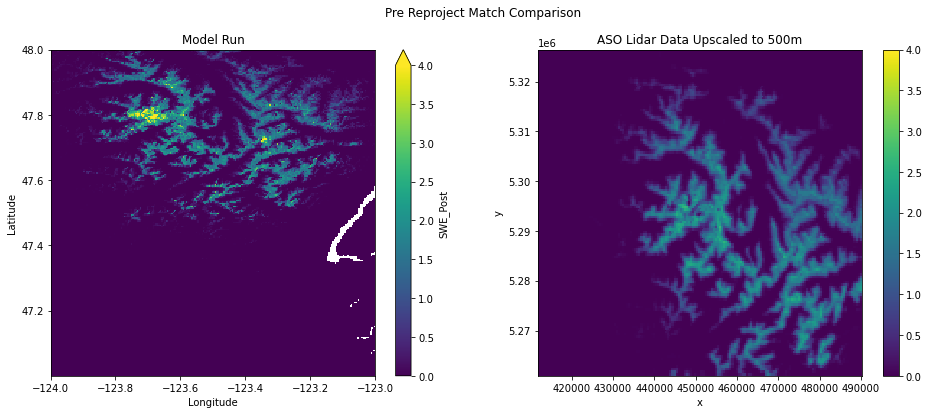

In [8]:
# comparing before reproject
f,ax = plt.subplots(1,2,figsize=(16,6))
model_ds.plot(ax=ax[0],vmin=0,vmax=4)
ax[0].set_title('Model Run')
ASO_500m_ds.plot(ax=ax[1],vmin=0,vmax=4)
ax[1].set_title('ASO Lidar Data Upscaled to 500m')
f.suptitle('Pre Reproject Match Comparison')

In [9]:
# mask out glaciers, shapefiles from http://www.glims.org/maps/glims
glaciers_gdf = gpd.read_file('data/Glacier_shapefiles/glims_polygons.shp')
model_clipped = model_ds.rio.clip(glaciers_gdf.geometry.apply(mapping), glaciers_gdf.crs,drop=False,invert=True,all_touched=True) # set invert True when looking at NON-glaciers
model_clipped_touchfalse = model_ds.rio.clip(glaciers_gdf.geometry.apply(mapping), glaciers_gdf.crs,drop=False,invert=True,all_touched=False) # set invert True when looking at NON-glaciers

In [10]:
# reprojecting
model_reproject_glacma = model_clipped.rio.reproject_match(ASO_500m_ds)
model_reproject_glacma_touchfalse = model_clipped_touchfalse.rio.reproject_match(ASO_500m_ds)
model_reproject = model_ds.rio.reproject_match(ASO_500m_ds)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Text(0.5, 0.98, 'Post Reproject Match Comparison')

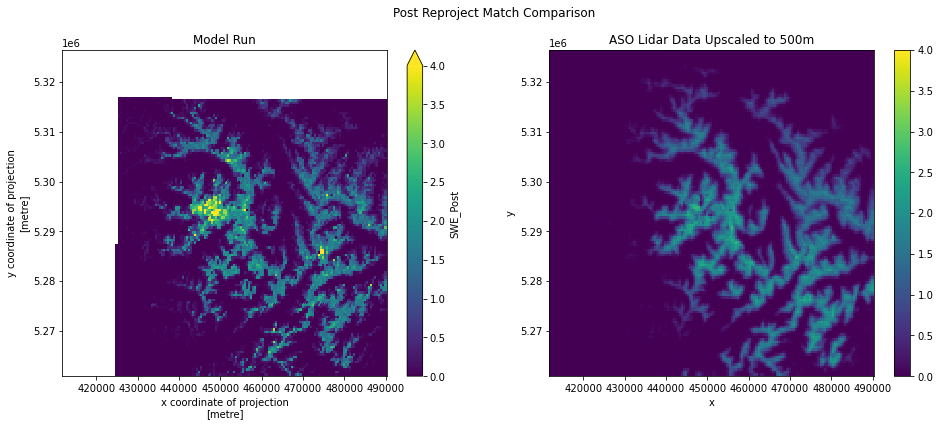

In [11]:
# post projection comparison
f, ax = plt.subplots(1,2,figsize=(16,6))
model_reproject.plot(ax=ax[0],vmin=0,vmax=4)
ax[0].set_title('Model Run')
ASO_500m_ds.plot(ax=ax[1],vmin=0,vmax=4)
ax[1].set_title('ASO Lidar Data Upscaled to 500m')
f.suptitle('Post Reproject Match Comparison')

In [12]:
# difference
model_reproject = model_reproject.sel(x=slice(4.3e5,4.9e5),y=slice(5.315e6,5.26e6))
model_reproject_glacma = model_reproject_glacma.sel(x=slice(4.3e5,4.9e5),y=slice(5.315e6,5.26e6))
ASO_500m_ds = ASO_500m_ds.sel(x=slice(4.3e5,4.9e5),y=slice(5.315e6,5.26e6))
difference =  model_reproject - ASO_500m_ds
difference_glacma =  model_reproject_glacma - ASO_500m_ds
difference_glacma_touchfalse =  model_reproject_glacma_touchfalse - ASO_500m_ds 

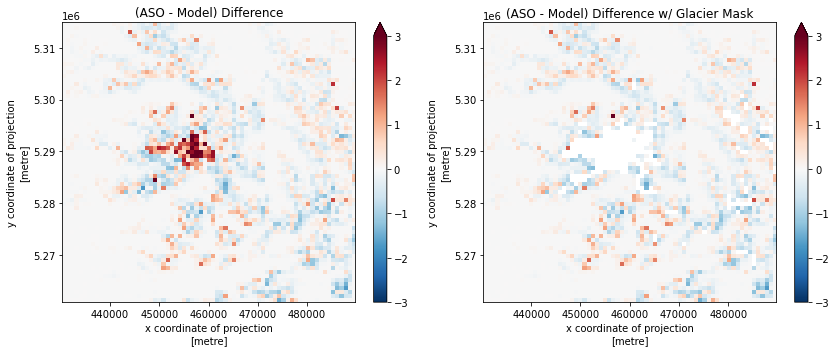

In [13]:
# show difference
f, ax = plt.subplots(1,2,figsize=(12,5))
difference.squeeze().plot.imshow(ax=ax[0],vmin=-3,vmax=3,cmap='RdBu_r',interpolation='none')
difference_glacma.squeeze().plot.imshow(ax=ax[1],vmin=-3,vmax=3,cmap='RdBu_r',interpolation='none')
ax[0].set_title('(ASO - Model) Difference')
ax[1].set_title('(ASO - Model) Difference w/ Glacier Mask')
plt.tight_layout()

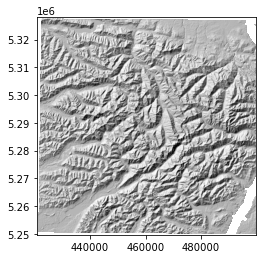

In [14]:
# create hillshade to plot on top of
olympics_bounds = (-124.05, 47.4, -123.0, 48.1)
demtype_list = ["SRTMGL3", "SRTMGL1", "SRTMGL1_E", "AW3D30", "AW3D30_E", "SRTM15Plus"]
demtype = demtype_list[0]
base_url="https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff"
base_url.format(demtype, *olympics_bounds)

def get_OT_GlobalDEM(demtype, bounds, out_fn=None):
    if out_fn is None:
        out_fn = '{}.tif'.format(demtype)
    
    if not os.path.exists(out_fn):
        #Prepare API request url
        #Bounds should be [minlon, minlat, maxlon, maxlat]
        url = base_url.format(demtype, *bounds)
        print(url)
        #Get
        response = requests.get(url)
        #Should check for 200
        #Write to disk
        open(out_fn, 'wb').write(response.content)
out_fn = f"data/DEMs/olympics_{demtype}.tif"
out_fn
get_OT_GlobalDEM(demtype, olympics_bounds, out_fn)
#!gdalinfo $out_fn
src = rio.open(out_fn)
#f, ax = plt.subplots()
srtm = src.read(1, masked=True)
#m = ax.imshow(srtm)
#plt.colorbar(m)
dst_crs = 'EPSG:32610'
proj_fn = os.path.splitext(out_fn)[0]+'_utm_gdalwarp.tif'
if not os.path.exists(proj_fn):
    !gdalwarp -r cubic -t_srs $dst_crs $out_fn $proj_fn
hs_fn = os.path.splitext(proj_fn)[0]+'_hs.tif'
if not os.path.exists(hs_fn):
    !gdaldem hillshade $proj_fn $hs_fn
hs_src = rio.open(hs_fn)
hs = hs_src.read(1, masked=True)
f, ax = plt.subplots()
hs_extent = rio.plot.plotting_extent(hs_src)
ax.imshow(hs, cmap='gray', extent=hs_extent);

Text(0.5, 0.98, 'Model and ASO Lidar Differencing on DOWY = 180 with Temperature Threshold = 0K')

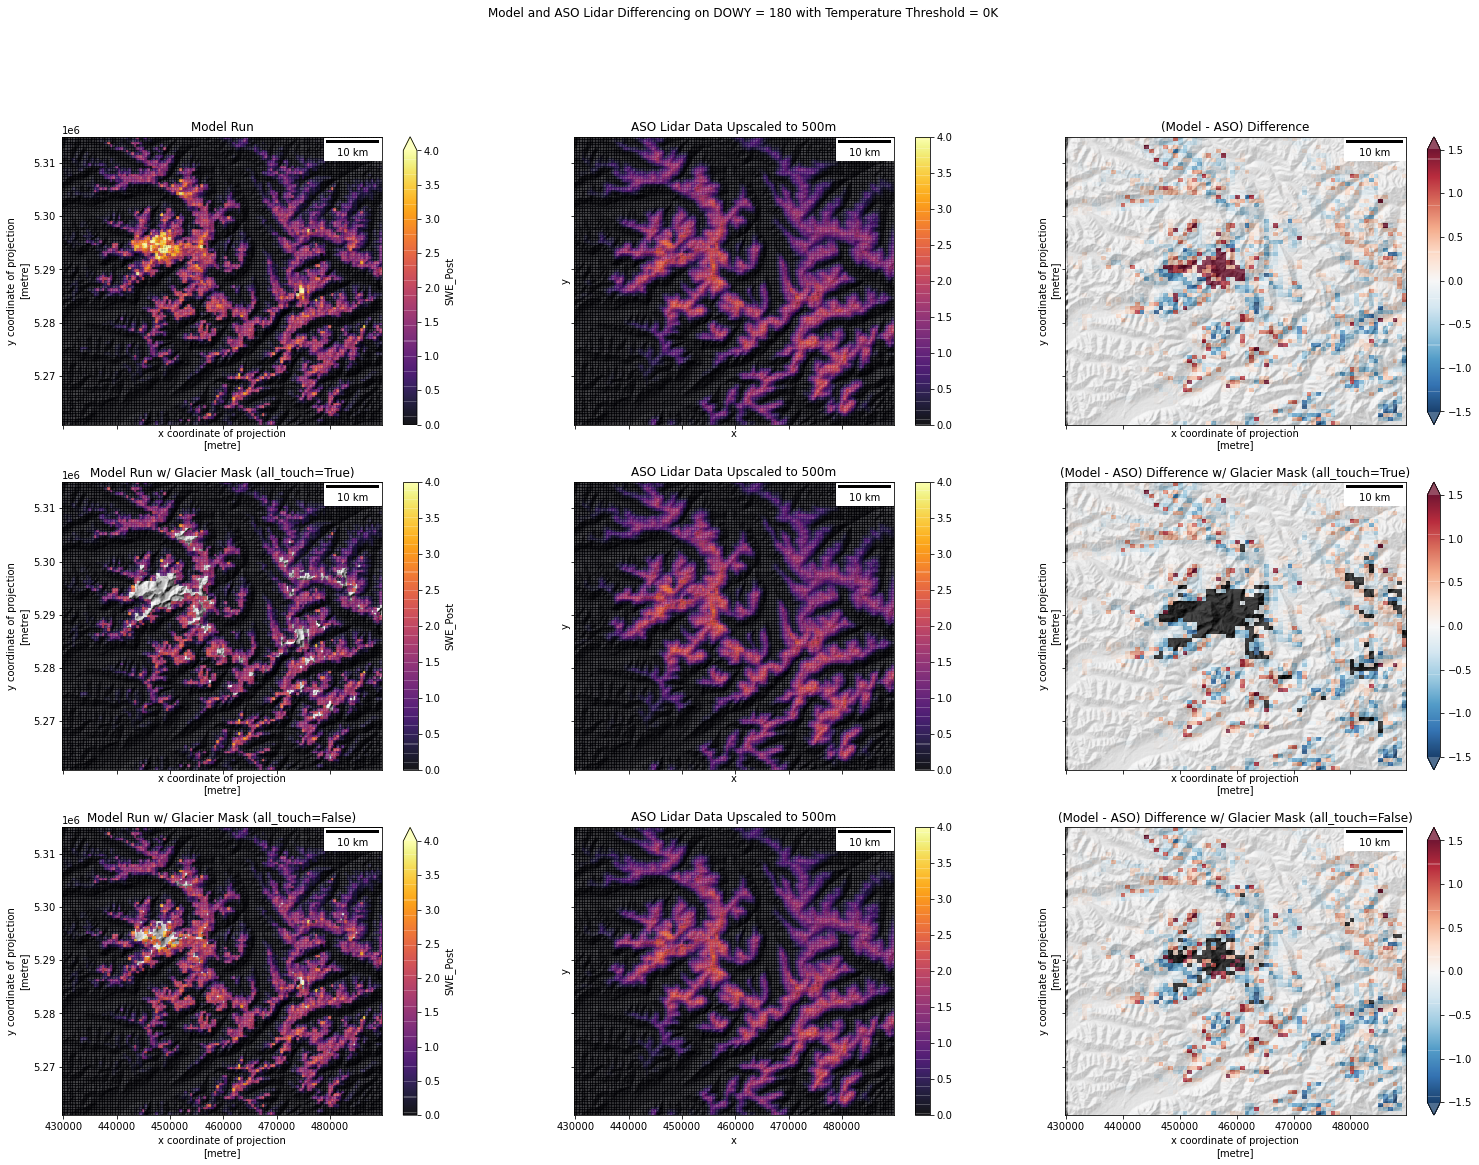

In [15]:
# plot differencing
f, ax = plt.subplots(3,3,figsize=(26,18),sharex=True,sharey=True) 

a = 0.7
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].imshow(hs, cmap='gray',extent=hs_extent)
        ax[i,j].set_xlim([431000, 490000])
        ax[i,j].set_ylim([5.262e6, 5.31e6])
        ax[i,j].add_artist(ScaleBar(1.0))

cmap = copy.copy(matplotlib.cm.RdBu_r)
cmap.set_bad('black',alpha=1)

model_reproject.plot(ax=ax[0,0],vmin=0,vmax=4,cmap='inferno',alpha=a)
ax[0,0].set_title('Model Run')
ASO_500m_ds.plot(ax=ax[0,1],vmin=0,vmax=4,cmap='inferno',alpha=a)
ax[0,1].set_title('ASO Lidar Data Upscaled to 500m')
difference.squeeze().plot.imshow(ax=ax[0,2],vmin=-1.5,vmax=1.5,cmap=cmap,alpha=a)
ax[0,2].set_title('(Model - ASO) Difference')

model_reproject_glacma.plot(ax=ax[1,0],vmin=0,vmax=4,cmap='inferno',alpha=a)
ax[1,0].set_title('Model Run w/ Glacier Mask (all_touch=True)')
ASO_500m_ds.plot(ax=ax[1,1],vmin=0,vmax=4,cmap='inferno',alpha=a)
ax[1,1].set_title('ASO Lidar Data Upscaled to 500m')
difference_glacma.squeeze().plot.imshow(ax=ax[1,2],vmin=-1.5,vmax=1.5,cmap=cmap,alpha=a)
ax[1,2].set_title('(Model - ASO) Difference w/ Glacier Mask (all_touch=True)')

model_reproject_glacma_touchfalse.plot(ax=ax[2,0],vmin=0,vmax=4,cmap='inferno',alpha=a)
ax[2,0].set_title('Model Run w/ Glacier Mask (all_touch=False)')
ASO_500m_ds.plot(ax=ax[2,1],vmin=0,vmax=4,cmap='inferno',alpha=a)
ax[2,1].set_title('ASO Lidar Data Upscaled to 500m')
difference_glacma_touchfalse.squeeze().plot.imshow(ax=ax[2,2],vmin=-1.5,vmax=1.5,cmap=cmap,alpha=a)
ax[2,2].set_title('(Model - ASO) Difference w/ Glacier Mask (all_touch=False)')

f.suptitle(f'Model and ASO Lidar Differencing on DOWY = {day_num} with Temperature Threshold = {threshold}K')